In [2]:
import requests
import pandas as pd
import numpy as np
import time
import scipy.stats as stats
import seaborn as sns
sns.set()

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from sklearn.preprocessing import FunctionTransformer, StandardScaler 
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn_pandas import DataFrameMapper

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]

In [3]:
def linear_wCoefs(xt, yt, xval, yval):
    lm = LinearRegression(fit_intercept=True)

    lm.fit(xt, yt)
    # score fit model on validation data
    val_score = lm.score(xval, yval)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    if lm.fit_intercept:
        print("Intercept : {:.8f}".format(lm.intercept_))
    
    for feature, coef in zip(xt.columns, lm.coef_):
        print(feature, ':', f'{coef:.8f}')
    
    pred = lm.predict(xval)
    
    xvar1 = xt.columns[0]
    #yvar = yt.columns[0]
    
    plt.subplot(1, 3, 1)
    plt.scatter(xval[xvar1],yval)
    #plt.plot(xval['Gold'], pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel(xvar1)
    plt.ylabel('y')
    
    plt.subplot(1, 3, 2)
    res = yval - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    
    #return lm, pred

In [4]:
GP_df = pd.read_csv('../Data/final_Data_for_Modeling.csv', parse_dates=['Date'])
#GP_df

In [5]:
GP_df['Gold_next'] = GP_df['Gold'].shift(periods=-1)
GP_df['Gold_1week'] = GP_df['Gold'].shift(periods=-5)
GP_df['Gold_4week'] = GP_df['Gold'].shift(periods=-28)
GP_df['Gold_prev'] = GP_df['Gold'].shift(periods=1)
# Gold percentge change (todays over previous close)
GP_df['Gold_chg'] = 100*(GP_df['Gold'] - GP_df['Gold_prev'])/GP_df['Gold_prev']
#
GP_df['GPInc'] = (GP_df['Gold_next']/GP_df['Gold']-1)
GP_df["year"]=pd.to_datetime(GP_df['Date'], format='%Y-%m-%d').dt.year - 2000
#GP_df

In [170]:
class GP_linear_scaled_model: 
    """
    
    
    Parameters:
    train_years
    test_years
    xvars: list of x variable column names
    yvars: list of y variable column names
    
    
    Methods:
    
    """

    def __init__(self,  GP_df, xvars, yvars, train_years = [2000, 2015], test_years = [2016]):
        self.train_years = train_years
        self.test_years = test_years
        
        self.xvars = xvars
        self.yvars = yvars
                 
        self.add_database(GP_df)
    
    def add_database(self, gold_df):
        train_year1_suffix = int(self.train_years[0] % 1000)
        train_year2_suffix = int(self.train_years[1] % 1000)
        test_year_suffix = int(self.test_years[-1] % 1000)
        
        train_set_def = (GP_df['year']>= train_year1_suffix) * (GP_df['year']<=train_year2_suffix)
        test_set_def = (GP_df['year']>train_year2_suffix) * (GP_df['year']<=test_year_suffix)
    
        self.xTrainDF = gold_df.loc[train_set_def, self.xvars].dropna(axis=0).copy()
        self.yTrainDF = gold_df.loc[train_set_def, self.xvars + [self.yvars]].dropna(axis=0)[self.yvars].copy()

        self.xTestDF = gold_df.loc[test_set_def, self.xvars].dropna(axis=0).copy()
        self.yTestDF = gold_df.loc[test_set_def, self.xvars + [self.yvars]].dropna(axis=0)[self.yvars].copy()
        
        # --- Other info to store from the parent dataframe
        yNext = gold_df.loc[test_set_def, self.yvars]
        self.yNaive = gold_df.loc[test_set_def, 'Gold']
        
        naive_r2 = r2_score(yNext, self.yNaive)
        naive_mse = mse(yNext, self.yNaive)
        naive_mae = mae(yNext, self.yNaive)
        naive_mape = 100*(np.mean(np.divide(np.abs(yNext - self.yNaive), yNext)))
        self.naive_scores = [naive_r2, naive_mse, naive_mae, naive_mape]
        
        self.test_dates = gold_df.loc[test_set_def, ['Date', 'year']].copy()

    #def naive_r2(self, gold_df):
    
    def linear_wCoefs(self):
        self.lm = LinearRegression(fit_intercept=True)
        self.lm.fit(self.xTrainDF, self.yTrainDF)
        self.pred = self.lm.predict(self.xTestDF)
        

    def print_linear_plot(self):
        # score fit model on validation data
        val_score = self.lm.score(self.xTestDF, self.yTestDF)
        
        # report results
        print('\nValidation R^2 score was:', val_score)
        print('Feature coefficient results: \n')
        if self.lm.fit_intercept:
            print("Intercept : {:.8f}".format(self.lm.intercept_))

        for feature, coef in zip(self.xvars, lm.coef_):
            print(feature, ':', f'{coef:.8f}')
        
        col = self.xvars[0]

        plt.subplot(1, 3, 1)
        plt.scatter(self.xTestDF.loc[:,col],self.yTestDF)
        #plt.plot(xval['Gold'], pred, color='blue',linewidth=1)
        plt.title("Regression fit")
        plt.xlabel(self.xvars[0])
        plt.ylabel('y')

        plt.subplot(1, 3, 2)
        res = self.yTestDF - self.pred
        plt.scatter(self.pred, res)
        plt.title("Residual plot")
        plt.xlabel("prediction")
        plt.ylabel("residuals")

        plt.subplot(1, 3, 3)
        #Generates a probability plot of sample data against the quantiles of a 
        # specified theoretical distribution 
        stats.probplot(res, dist="norm", plot=plt)
        plt.title("Normal Q-Q plot")

    
    def fit(self):
        self.linear_wCoefs()
        self.fit2()

    def fit2(self):
        self.fit2 = sm.OLS(self.yTrainDF, self.xTrainDF).fit()
        self.yhat = self.fit2.predict(self.xTestDF)
        self.get_scores()
        self.fit2.summary()
    
    def get_scores(self):
        self.pred_r2 = r2_score(self.yTestDF, self.yhat)
        self.mse = mse(self.yTestDF, self.yhat)
        self.mae = mae(self.yTestDF, self.yhat)
        self.mape = 100*(np.mean(np.divide(np.abs(self.yTestDF - self.yhat), self.yTestDF)))
        
        self.scores = [self.pred_r2, self.mse, self.mae, self.mape]
    
    def get_timemap(self):
        #
        c1 = '#fde09d'
        c2 = '#d89f39'
        c3 = '#8e6f36'
        c4 = '#ff9900'
        
        print("Naive solution R2: {:.8f}".format(self.naive_scores[0]))
        print("Prediction solution R2: {:.8f}".format(self.pred_r2))
        
        plt.xticks(size = 15)
        plt.yticks(size = 15)

        # Gold price - Blue line
        plt.plot(self.test_dates['Date'], self.yNaive, c=c3, linewidth=2, label="Actual");

        # Gold price prediction - Orange line
        plt.plot(self.test_dates['Date'], pd.Series(self.yhat).shift(periods=1), c=c4, label="Forecast")
        plt.legend(loc='upper left', fontsize = 20)
        
        plt.xlabel("Dates", fontweight='bold', size = 20, labelpad=10)
        plt.ylabel("Gold Price $/oz", fontweight='bold', size = 20, labelpad=10)
        plt.title("Year 2016 Gold Price ($/oz): Forecasted vs Actual", fontweight='bold', size = 20)
        
    def compare_y_plot(self):
        #
        c1 = '#fde09d'
        c2 = '#d89f39'
        c3 = '#8e6f36'
        c4 = '#ff9900'
        colors = {16:'#ff9900', 17:'blue', 18:'green'}
        cols = self.test_dates['year'].apply(lambda x: colors[x])


        plt.rcParams['figure.figsize'] = [10, 10]
        plt.scatter(self.yTestDF, self.yhat, c = c4);

        #for i in range(16,17):
        #    plt.scatter(1200, 1200, c = colors[i], alpha=0.5, label = "20{} Gold Prices".format(i));
        
        plt.xticks(size = 15)
        plt.yticks(size = 15)


        x_fit_line=[x for x in range(1090, 1360)]
        plt.plot(x_fit_line, x_fit_line, c="k",)
        plt.xlabel("Actual Gold Price $/oz", fontweight='bold', size = 20, labelpad=10)
        plt.ylabel("Predicted Gold Price $/oz", fontweight='bold', size = 20, labelpad=10)
        plt.title("Year 2016 Gold Price ($/oz)", fontweight='bold', size = 20)
        plt.text(1070, 1340, "R-Squared for Training Set = 1.00", size = 20)
        plt.text(1070, 1320, "R-Squared for Test Set = {:.3f}".format(self.scores[0]), size = 20)
        #plt.legend(loc='upper left', size = 20)

    


In [7]:
x_vars2 = ['Gold', 'GoldFutures','Silver', 'Platinum', 'Palladium', 'OilSpot', \
             'DJI', 'FTSE', 'TBill', 'FedFundRates', 'USDX']
y_var2 = 'Gold_next'

gp16 = GP_linear_scaled_model(GP_df, x_vars2, y_var2, train_years=[2000, 2015], test_years=[2016])
gp16.fit()
gp16.fit2.summary()

//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Gold_next   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.451e+06
Date:                Fri, 11 Oct 2019   Prob (F-statistic):                        0.00
Time:                        05:25:21   Log-Likelihood:                         -15277.
No. Observations:                3934   AIC:                                  3.058e+04
Df Residuals:                    3923   BIC:                                  3.065e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Gold             0.8509      0.009     95.048      0.000       0.833       0.868
GoldFutures      0.1397      0.008     16.502      0.000       0.123       0.156
Silver           0.5758      0.092      6.280      0.000       0.396       0.756
Platinum         0.0079      0.002      5.122      0.000       0.005       0.011
Palladium       -0.0141      0.002     -8.442      0.000      -0.017      -0.011
OilSpot         -0.1112      0.020     -5.466      0.000      -0.151      -0.071
DJI             -0.0017      0.000     -6.885      0.000      -0.002      -0.001
FTSE             0.0035      0.001      3.420      0.001       0.001       0.005
TBill           -2.3405      0.542     -4.322      0.000      -3.402      -1.279
FedFundRates     0.6980      0.258      2.703      0.007       0.192       1.204
USDX             0.1293      0.022      5.783      0.000       0.085       0.173
==============================================================================
Omnibus:                     1397.931   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           544887.684
Skew:                          -0.185   Prob(JB):                         0.00
Kurtosis:                      60.654   Cond. No.                     3.91e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
print("Year 2016 predictions: {}".format(gp16.scores))

Year 2016 predictions: [0.9719287790977198, 146.97703887496, 8.793157272633541, 0.7037396390133442]


In [80]:
scores={}
naive_scores = {}
for i in range(2005, 2018):
    model = GP_linear_scaled_model(GP_df, x_vars2, y_var2, train_years=[2000, i], test_years=[i+1])
    model.fit()
    #model.fit2.summary()
    naive_scores[i+1] = model.naive_scores
    scores[i+1] = model.scores
    print("Year {} Naive preds: {}".format(i+1, model.naive_scores))
    print("Year {} predictions: {}".format(i+1, model.scores))
    print('\n')


//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, 

Year 2006 Naive preds: [0.9498342105357946, 80.09653061224488, 6.334285714285713, 1.0331965713794786]
Year 2006 predictions: [0.9745873749771464, 40.57472472416388, 4.667452673750737, 0.7595760416500454]


Year 2007 Naive preds: [0.8760802614810412, 444.77535714285716, 6.855714285714286, 0.9639698402086175]
Year 2007 predictions: [0.9393162431968679, 217.80742864264505, 4.454392747002543, 0.6014985900731031]


Year 2008 Naive preds: [0.9385562203071772, 278.6157730923695, 12.171285140562249, 1.4146781584009342]
Year 2008 predictions: [0.9688830507909516, 141.09927650117712, 8.90221448221445, 1.0346395091470961]


Year 2009 Naive preds: [0.9779570286071417, 160.4758064516129, 9.46975806451613, 0.9669682437914529]
Year 2009 predictions: [0.9823169553946846, 128.7349510636863, 8.765062272774234, 0.9049696045737634]


Year 2010 Naive preds: [0.9852138935874847, 145.5087854251012, 9.214574898785425, 0.7501869048045988]
Year 2010 predictions: [0.993130192487269, 67.60517741409095, 6.32253005

//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, 

//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


Naive solution R2: 0.98601701
Prediction solution R2: 0.43518191


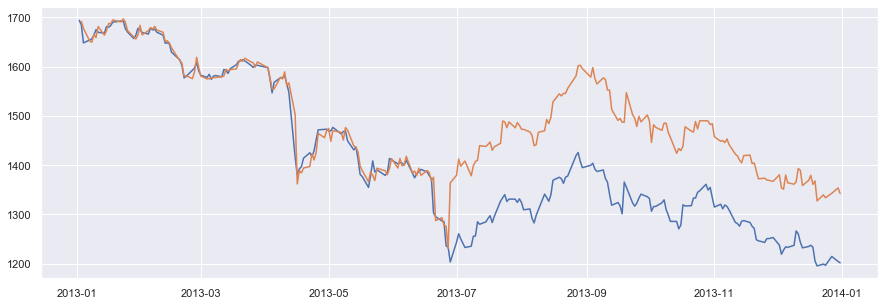

In [81]:
plt.rcParams['figure.figsize'] = [15, 5]
gp13 = GP_linear_scaled_model(GP_df, x_vars2, y_var2, train_years=[2000, 2012], test_years=[2013])
gp13.fit()
gp13.fit2.summary()
gp13.get_timemap()

//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


Naive solution R2: 0.99178702
Prediction solution R2: 0.56458194


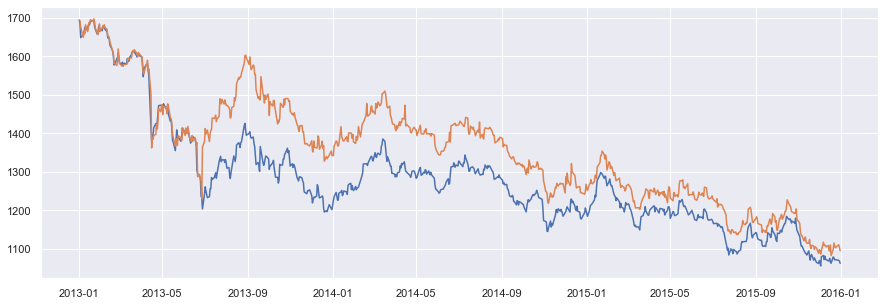

In [83]:
gp14 = GP_linear_scaled_model(GP_df, x_vars2, y_var2, train_years=[2000, 2012], test_years=[2013, 2015])
gp14.fit()
gp14.fit2.summary()
gp14.get_timemap()

//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


Naive solution R2: 0.97152412
Prediction solution R2: 0.97192878


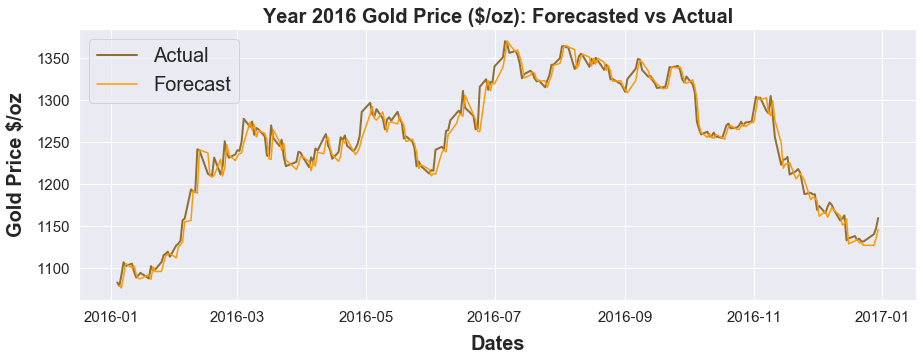

In [171]:
plt.rcParams['figure.figsize'] = [15, 5]
gp16 = GP_linear_scaled_model(GP_df, x_vars2, y_var2, train_years=[2000, 2015], test_years=[2016])
gp16.fit()
gp16.fit2.summary()
gp16.get_timemap()

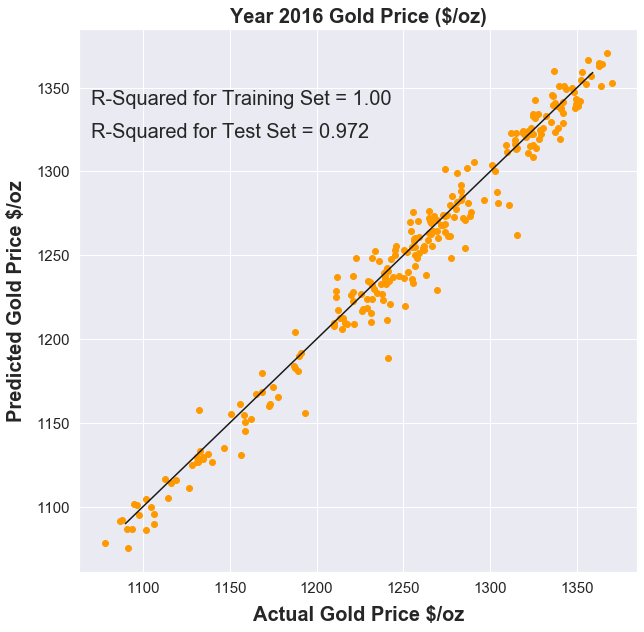

In [157]:
gp16.compare_y_plot()

In [95]:
maes = [int(v[-2]*100)/100 for k, v in scores.items()]
years = [k for k, v in scores.items()]
naive_maes = [int(v[-2]*100)/100 for k, v in naive_scores.items()]
print(years)
print(maes)
print(naive_maes)
print(scores[2016])
print(naive_scores[2016])

[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
[4.66, 4.45, 8.9, 8.76, 6.32, 10.73, 9.31, 82.26, 7.8, 8.64, 8.79, 10.47, 8.51]
[6.33, 6.85, 12.17, 9.46, 9.21, 15.02, 11.55, 11.46, 7.55, 7.33, 8.87, 6.48, 5.39]
[0.9719287790977198, 146.97703887496, 8.793157272633541, 0.7037396390133442]
[0.9715241242056362, 149.09575604838707, 8.876008064516132, 0.7092283928078821]


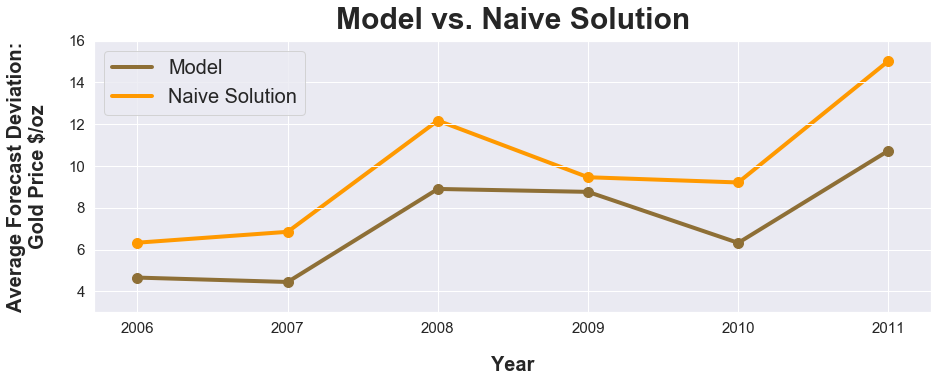

In [148]:
c1 = '#fde09d'
c2 = '#d89f39'
c3 = '#8e6f36'
c4 = '#ff9900'

plt.ylim(3,16)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.plot(years[:6], maes[:6],  c=c3, linewidth=4, label="Model")
plt.scatter(years[:6], maes[:6],s=100, c=c3, marker='o')

plt.scatter(years[:6], naive_maes[:6], s=100, c=c4, marker='o', zorder=1)
plt.plot(years[:6], naive_maes[:6], c=c4, linewidth=4, zorder=0, label="Naive Solution")


plt.xlabel("Year", fontweight='bold', size = 20, labelpad=20)
plt.ylabel("Average Forecast Deviation:\nGold Price $/oz", fontweight='bold', size = 20, labelpad=20)
plt.title("Model vs. Naive Solution", fontweight='bold', size = 30, y=1.02)

plt.legend(loc='upper left', fontsize=20)

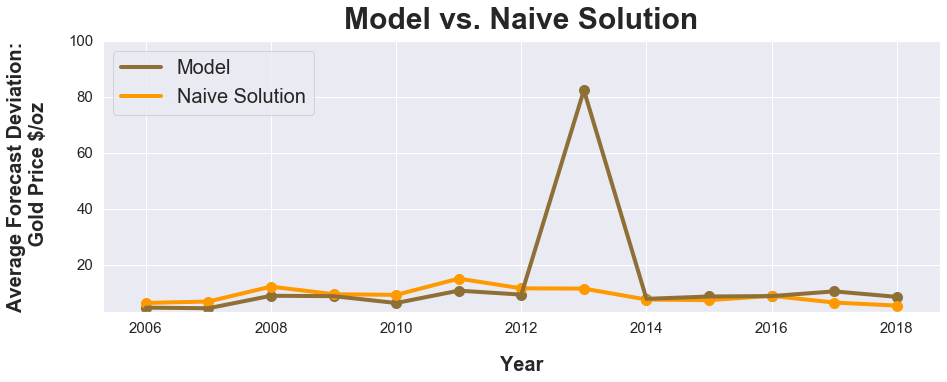

In [146]:
plt.rcParams['figure.figsize'] = [15, 5]

c1 = '#fde09d'
c2 = '#d89f39'
c3 = '#8e6f36'
c4 = '#ff9900'

plt.ylim(3,100)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.plot(years[:], maes[:],  c=c3, linewidth=4, label="Model")
plt.scatter(years[:], maes[:],s=100, c=c3, marker='o')

plt.scatter(years[:], naive_maes[:], s=100, c=c4, marker='o', zorder=1)
plt.plot(years[:], naive_maes[:], c=c4, linewidth=4, zorder=0, label="Naive Solution")


plt.xlabel("Year", fontweight='bold', size = 20, labelpad=20)
plt.ylabel("Average Forecast Deviation:\n Gold Price $/oz", fontweight='bold', size = 20, labelpad=20)
plt.title("Model vs. Naive Solution", fontweight='bold', size = 30, y=1.02)

plt.legend(loc='upper left', fontsize=20)